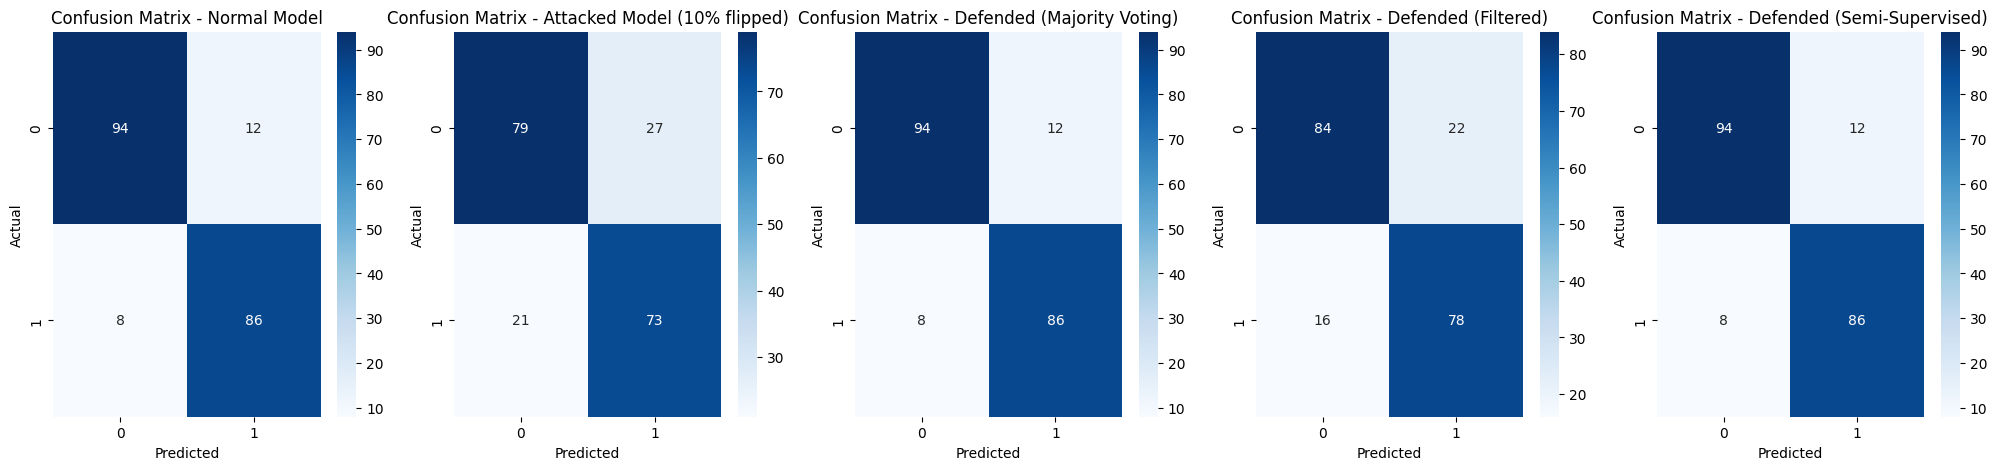

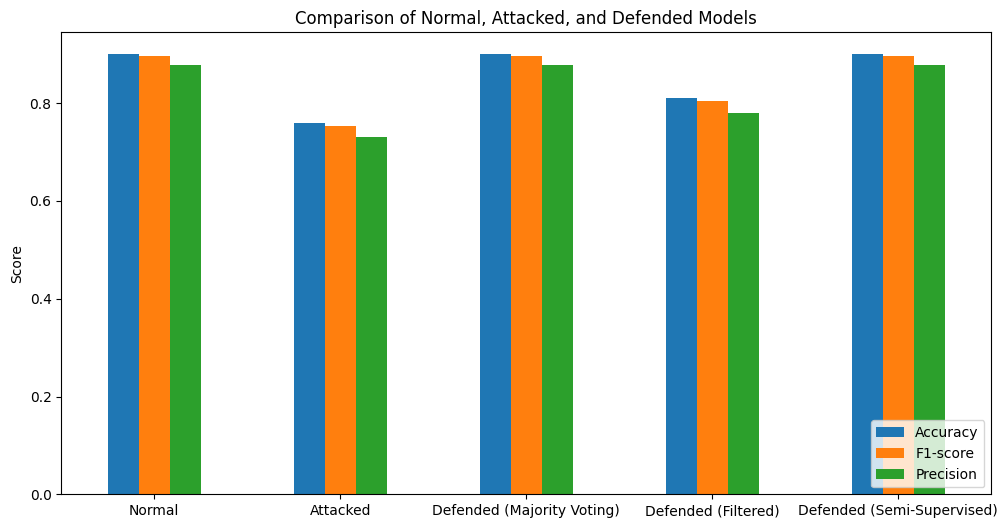

                            Accuracy  F1-score  Precision
Normal                          0.90  0.895833   0.877551
Attacked                        0.76  0.752577   0.730000
Defended (Majority Voting)      0.90  0.895833   0.877551
Defended (Filtered)             0.81  0.804124   0.780000
Defended (Semi-Supervised)      0.90  0.895833   0.877551


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.datasets import make_classification
from scipy.stats import mode

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a normal RandomForest model
clf_normal = RandomForestClassifier(random_state=42)
clf_normal.fit(X_train, y_train)
y_pred_normal = clf_normal.predict(X_test)

# Introduce an attack: Label Flipping (10% of training labels flipped)
np.random.seed(42)
flip_indices = np.random.choice(len(y_train), size=int(0.35 * len(y_train)), replace=False)
y_train_attacked = y_train.copy()
y_train_attacked[flip_indices] = 1 - y_train_attacked[flip_indices]

# Train a model on the attacked dataset
clf_attacked = RandomForestClassifier(random_state=42)
clf_attacked.fit(X_train, y_train_attacked)
y_pred_attacked = clf_attacked.predict(X_test)

# Defense Attempt 1: Majority Voting
y_train_defended = y_train.copy()
for idx in flip_indices:
    neighborhood = np.delete(y_train_attacked, idx)
    y_train_defended[idx] = mode(neighborhood, keepdims=True)[0][0]

clf_defended = RandomForestClassifier(random_state=42)
clf_defended.fit(X_train, y_train_defended)
y_pred_defended = clf_defended.predict(X_test)

# Defense Attempt 2: Uncertainty Filtering with SVM
svm_detector = SVC(probability=True, random_state=42)
svm_detector.fit(X_train, y_train_attacked)
prob_scores = svm_detector.predict_proba(X_train)
uncertain_samples = np.max(prob_scores, axis=1) < 0.6
X_train_defended = X_train[~uncertain_samples]
y_train_defended = y_train_attacked[~uncertain_samples]

clf_defended_filtered = RandomForestClassifier(random_state=42)
clf_defended_filtered.fit(X_train_defended, y_train_defended)
y_pred_defended_filtered = clf_defended_filtered.predict(X_test)

# Defense Attempt 3: Semi-Supervised Learning
clf_self_training = RandomForestClassifier(random_state=42)
clf_self_training.fit(X_train, y_train)
y_train_pseudo = clf_self_training.predict(X_train)
y_train_defended_semi = y_train_attacked.copy()
y_train_defended_semi[flip_indices] = y_train_pseudo[flip_indices]

clf_defended_semi = RandomForestClassifier(random_state=42)
clf_defended_semi.fit(X_train, y_train_defended_semi)
y_pred_defended_semi = clf_defended_semi.predict(X_test)

# Function to compute evaluation metrics
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred)
    }

# Compute evaluation metrics
metrics_normal = evaluate_model(y_test, y_pred_normal)
metrics_attacked = evaluate_model(y_test, y_pred_attacked)
metrics_defended = evaluate_model(y_test, y_pred_defended)
metrics_defended_filtered = evaluate_model(y_test, y_pred_defended_filtered)
metrics_defended_semi = evaluate_model(y_test, y_pred_defended_semi)

# Convert metrics to DataFrame for visualization
metrics_df = pd.DataFrame([
    metrics_normal, metrics_attacked, metrics_defended,
    metrics_defended_filtered, metrics_defended_semi],
    index=['Normal', 'Attacked', 'Defended (Majority Voting)', 'Defended (Filtered)', 'Defended (Semi-Supervised)'])

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, (y_pred, title) in enumerate(zip(
        [y_pred_normal, y_pred_attacked, y_pred_defended, y_pred_defended_filtered, y_pred_defended_semi],
        ['Normal Model', 'Attacked Model (10% flipped)', 'Defended (Majority Voting)', 'Defended (Filtered)', 'Defended (Semi-Supervised)'])):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {title}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.show()

# Bar Chart for Accuracy, F1-score, and Precision
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of Normal, Attacked, and Defended Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Display metrics table
print(metrics_df)
